In [61]:
import os
from pathlib import Path
from copy import deepcopy
from tqdm import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset

from NegativeClassOptimization import config, utils, preprocessing, ml, pipelines, datasets, visualisations

In [3]:
split_seed = 0
model_trin_seed = 0
model_type = "SNN"

# Standard parameters
epochs = 50
learning_rate = 0.001
optimizer_type = "Adam"
momentum = 0.9
weight_decay = 0
batch_size = 64

num_hidden_units = 10
input_dim = 220


In [4]:
#n_partitions = 10
n_partitions = 26
titration_partitions = np.arange(0, 20000*(n_partitions+1), 40000)

In [6]:
def prepare_ml_data_dfs(df, binary_class, seed):
    df['y'] = binary_class
    df['binds_a_pos_ag'] = binary_class
    df['X'] = df['Slide'].apply(preprocessing.onehot_encode)
    df_train, df_test, _ = utils.split_to_train_test_rest_dfs(15000,5000, df, random_state=seed)
    return df_train, df_test

def create_titrated_datasets(ag, path_to_save_res):
    df_ab = utils.load_binding_per_ag(ag)
    df_ab.sort_values('Energy', ascending=True, inplace=True)
    df_ab.drop_duplicates('Slide', keep='first', inplace=True)
    os.makedirs(path_to_save_res, exist_ok=True)
    df_binders = df_ab.query('Source=="mascotte"').copy()
    
    df_pos = df_binders.sample(20000, random_state=split_seed)
    df_pos_train, df_pos_test = prepare_ml_data_dfs(df_pos, 1, split_seed)

    df_neg = df_ab.query('Source != "mascotte"').copy()
    df_neg.sort_values('Energy', ascending=True, inplace=True)

    for i in range(1, n_partitions+1):
        df_negative = df_neg.iloc[titration_partitions[i-1]:titration_partitions[i]].copy()
        df_negative.reset_index(drop=True, inplace=True)
        df_neg_train, df_neg_test = prepare_ml_data_dfs(df_negative, 0, split_seed)

        df_binary_train = pd.concat([df_pos_train, df_neg_train])
        df_binary_train.reset_index(drop=True, inplace=True)
        df_binary_test = pd.concat([df_pos_test, df_neg_test]).sample(frac=1)
        df_binary_test.reset_index(drop=True, inplace=True)

        df_binary_train.to_pickle(path_to_save_res / f'{ag}_train_weak_partition_{i}.pkl')
        df_binary_test.to_pickle(path_to_save_res / f'{ag}_test_weak_partition_{i}.pkl')


In [7]:
['3VRL','1NSN','3RAJ','5E94','1H0D','1WEJ','1ADQ','1FBI','2YPV','1OB1']

['3VRL',
 '1NSN',
 '3RAJ',
 '5E94',
 '1H0D',
 '1WEJ',
 '1ADQ',
 '1FBI',
 '2YPV',
 '1OB1']

In [ ]:
from concurrent.futures import ThreadPoolExecutor

def create_titrated_datasets_per_ag(ag):
    path_to_save_res = config.DATA_BASE_PATH / f"Titrated_binary_datasets/{ag}"
    create_titrated_datasets(ag, path_to_save_res)
    print(f"Done for {ag}")

EXECUTE = False # Not to calculate again
if EXECUTE:
    with ThreadPoolExecutor() as executor:
        list(executor.map(create_titrated_datasets_per_ag, config.ANTIGENS))


In [15]:
#check that titartion actually worked (check for at leasr one antigen)
min_max = []
for i in range(1,n_partitions+1):
    path_to_1adq_part = config.DATA_BASE_PATH / f"Titrated_binary_datasets/1ADQ/1ADQ_train_weak_partition_{i}.pkl"
    df_neg_part = pd.read_pickle(path_to_1adq_part).query('y==0')
    min_max.append((df_neg_part['Energy'].min(), df_neg_part['Energy'].max()))


In [16]:
min_max

[(-94.18, -93.42),
 (-93.42, -92.81),
 (-92.81, -92.32),
 (-92.32, -91.88),
 (-91.88, -91.51),
 (-91.51, -91.18),
 (-91.18, -90.88),
 (-90.88, -90.61),
 (-90.61, -90.37),
 (-90.37, -90.14),
 (-90.14, -88.76),
 (-88.76, -86.97),
 (-86.97, -85.73),
 (-85.73, -84.71),
 (-84.71, -83.81),
 (-83.81, -83.01),
 (-83.01, -82.27),
 (-82.27, -81.57),
 (-81.57, -80.91),
 (-80.91, -80.27),
 (-80.27, -79.6),
 (-79.6, -78.91),
 (-78.91, -78.22),
 (-78.22, -77.51),
 (-77.51, -76.74),
 (-76.74, -75.84)]

### Train and save models

In [18]:
def train_model_for_ag(ag):
    path_to_save_res = config.DATA_BASE_PATH / f"Titrated_binary_datasets/{ag}"
    for partition in range(1, n_partitions+1):
        #prepare data
        df_train = pd.read_pickle(path_to_save_res / f"{ag}_train_weak_partition_{partition}.pkl")
        df_train = datasets.BinaryDataset(df_train)
        df_test = pd.read_pickle(path_to_save_res / f"{ag}_test_weak_partition_{partition}.pkl")
        df_test = datasets.BinaryDataset(df_test)
        train_loader = DataLoader(df_train, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(df_test, batch_size=batch_size, shuffle=False)

        #prepare model and train
        model = ml.SNN(num_hidden_units, input_dim)        
        train_output = ml.train_for_ndb1(
            epochs,
            learning_rate,
            train_loader,
            test_loader,
            None,  # open_loader
            model,
            optimizer_type=optimizer_type,
            momentum=momentum,
            weight_decay=weight_decay,
            callback_on_model_end_epoch=None,
            swa=True,
        )

        #save model
        swa_model, model, online_metrics = train_output
        torch.save(model.state_dict(), path_to_save_res / f"{ag}_model_partiotion_{partition}.pt")
        torch.save(swa_model.state_dict(), path_to_save_res / f"{ag}_swa_model_partiotion_{partition}.pt")
        print(f"Done for {ag} partition {partition}")

In [ ]:
if EXECUTE:
    with ThreadPoolExecutor() as executor:
        list(executor.map(train_model_for_ag, config.ANTIGENS))

Epoch 1
-------------------------------Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------

Epoch 1
-------------------------------
Epoch 1
-------------------------------
loss: 0.704759  [    0/30000]
loss: 0.693370  [    0/30000]
loss: 0.694848  [    0/30000]
loss: 0.692008  [    0/30000]
loss: 0.696956  [    0/30000]
loss: 0.715627  [    0/30000]
loss: 0.694740  [    0/30000]
loss: 0.684104  [    0/30000]
loss: 0.703958  [    0/30000]
loss: 0.712552  [    0/30000]
loss: 0.681446  [ 6400/30000]
loss: 0.689565  [ 6400/30000]
loss: 0.683097  [ 6400/30000]
loss: 0.697060  [ 6400/30000]
loss: 0.683147  [ 6400/30000]
loss: 0.677528  [ 6400/30000]
loss: 0.688676  [ 6400/30000]
loss: 0.688997  [ 6400/30000]
loss: 0.690069  [ 6400/30000]
loss: 0.674118  [ 6400/30000]


In [ ]:
1021/60

17.016666666666666

### Evaluating models

In [8]:
def evaluate_model(
    model: torch.nn.Module,
    test_dataset: pd.DataFrame,
):
    """
    Evaluates a model on a test dataset.
    """
    with torch.no_grad():
        X = np.stack(test_dataset["X"])  # type: ignore
        X = torch.from_numpy(X).float()
        y_pred = model(X).round().detach().numpy().reshape(-1)
        y_true = test_dataset["binds_a_pos_ag"].values
        metrics = ml.compute_binary_metrics(y_pred, y_true)
    return metrics

#### ID performance

In [9]:
id_metrics_by_partition = [] #defaultdict(dict) #or maybe even default dict
for ag in config.ANTIGENS:
    path_to_save_res = config.DATA_BASE_PATH / f"Titrated_binary_datasets/{ag}"
    for partition in range(1, n_partitions+1):
        #load model
        state_dict = torch.load(path_to_save_res / f"{ag}_swa_model_partiotion_{partition}.pt")
        model = ml.load_model_from_state_dict(state_dict)
        #test data
        id_test_df = pd.read_pickle(path_to_save_res / f"{ag}_test_weak_partition_{partition}.pkl")
        metrics = evaluate_model(model, id_test_df)
        id_metrics_by_partition.append([ag, partition, 'ID']+ list(metrics.values()))
df_id_mertrics = pd.DataFrame(id_metrics_by_partition, columns=['Ag', 'Partition', 'Test type']+list(metrics.keys()))


#### OOD vs Non-binder

In [46]:
def load_ood_test_data(ood_task, ag):
    fp_loader = config.DATA_ML
    loader = datasets.FrozenMiniAbsolutMLLoader(data_dir=Path(fp_loader))
    task_spec = datasets.ClassificationTask(
        task_type=ood_task,
        ag_pos=ag,
        ag_neg="auto",
        seed_id=0,
        split_id=42)
    task = loader.load(task_spec, load_model=False, load_test_dataset=True, load_train_dataset=False)
    df_test_open = task.test_dataset
    df_test_open['X'] = df_test_open['Slide'].apply(preprocessing.onehot_encode)
    return df_test_open
    

In [47]:
NB_ood_metrics_by_partition = [] #defaultdict(dict) #or maybe even default dict
for ag in config.ANTIGENS:
    path_to_save_res = config.DATA_BASE_PATH / f"Titrated_binary_datasets/{ag}"
    for partition in range(1, 11):
        #load model
        state_dict = torch.load(path_to_save_res / f"{ag}_swa_model_partiotion_{partition}.pt")
        model = ml.load_model_from_state_dict(state_dict)
        #test data
        ood_test_df = load_ood_test_data(datasets.ClassificationTaskType.HIGH_VS_95LOW, ag)  
        metrics = evaluate_model(model, ood_test_df)
        NB_ood_metrics_by_partition.append([ag, partition, 'NB OOD']+ list(metrics.values()))
df_ood_nb_mertrics = pd.DataFrame(NB_ood_metrics_by_partition, columns=['Ag', 'Partition', 'Test type']+list(metrics.keys()))


KeyboardInterrupt: 

In [ ]:
WEAK_ood_metrics_by_partition = [] #defaultdict(dict) #or maybe even default dict
for ag in config.ANTIGENS:
    path_to_save_res = config.DATA_BASE_PATH / f"Titrated_binary_datasets/{ag}"
    for partition in range(5, n_partitions+1):
        #load model
        state_dict = torch.load(path_to_save_res / f"{ag}_swa_model_partiotion_{partition}.pt")
        model = ml.load_model_from_state_dict(state_dict)
        #test data
        ood_test_df = load_ood_test_data(datasets.ClassificationTaskType.HIGH_VS_LOOSER, ag)  
        metrics = evaluate_model(model, ood_test_df)
        WEAK_ood_metrics_by_partition.append([ag, partition, 'Weak OOD']+ list(metrics.values()))
df_ood_weak_mertrics = pd.DataFrame(WEAK_ood_metrics_by_partition, columns=['Ag', 'Partition', 'Test type']+list(metrics.keys()))

In [ ]:
vs9_ood_metrics_by_partition = [] #defaultdict(dict) #or maybe even default dict
for ag in config.ANTIGENS:
    path_to_save_res = config.DATA_BASE_PATH / f"Titrated_binary_datasets/{ag}"
    for partition in range(1, n_partitions+1):
        #load model
        state_dict = torch.load(path_to_save_res / f"{ag}_swa_model_partiotion_{partition}.pt")
        model = ml.load_model_from_state_dict(state_dict)
        #test data
        ood_test_df = load_ood_test_data(datasets.ClassificationTaskType.ONE_VS_NINE, ag)  
        metrics = evaluate_model(model, ood_test_df)
        vs9_ood_metrics_by_partition.append([ag, partition, 'vs9 OOD']+ list(metrics.values()))
df_ood_vs9_mertrics = pd.DataFrame(vs9_ood_metrics_by_partition, columns=['Ag', 'Partition', 'Test type']+list(metrics.keys()))


In [74]:
titration_partitions/(20000*(n_partitions+1))*100

array([ 0.        ,  7.40740741, 14.81481481, 22.22222222, 29.62962963,
       37.03703704, 44.44444444, 51.85185185, 59.25925926, 66.66666667,
       74.07407407, 81.48148148, 88.88888889, 96.2962963 ])

In [76]:
7*10

70

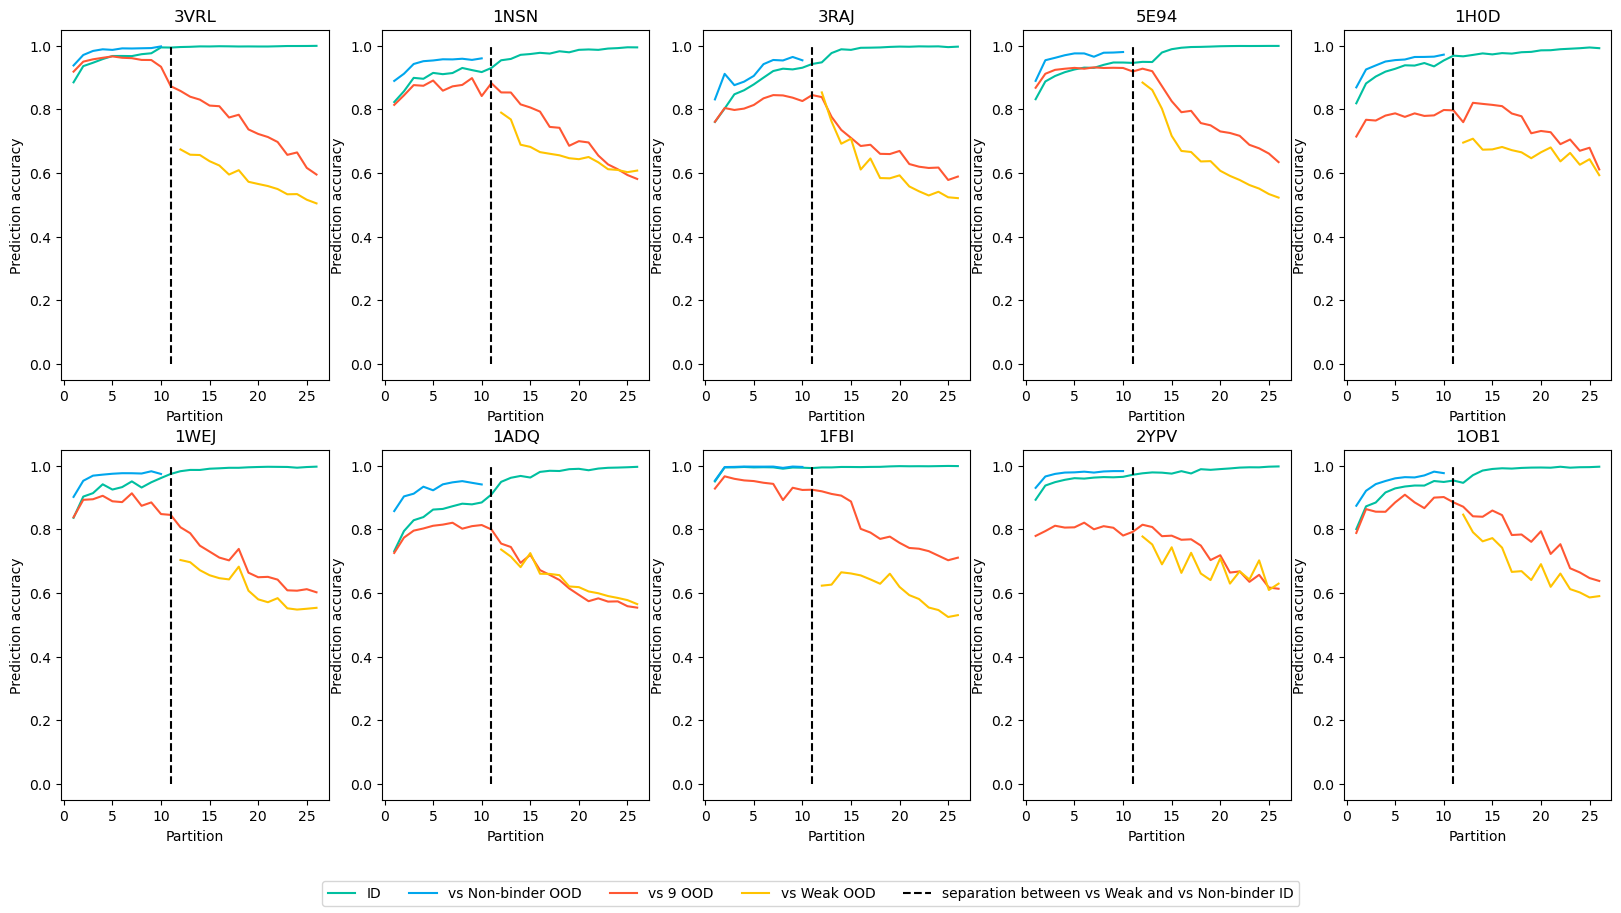

In [71]:
plt.rcParams['svg.fonttype'] = 'none'
fig, ax = plt.subplots(2,5, figsize=(20,10))
colors = ['#00BFA0','#00A6ED', '#FF5733','#FFC300']

for i, ag in enumerate(config.ANTIGENS):
    sns.lineplot(data=df_id_mertrics.query('Ag == @ag'), x='Partition', y='acc',  ax=ax[i//5, i%5], label='ID', legend=False, color=colors[0])
    sns.lineplot(data=df_ood_nb_mertrics.query('Ag == @ag'), x='Partition', y='acc',  ax=ax[i//5, i%5], label='vs Non-binder OOD', legend=False, color=colors[1])
    sns.lineplot(data=df_ood_vs9_mertrics.query('Ag == @ag'), x='Partition', y='acc',  ax=ax[i//5, i%5], label='vs 9 OOD', legend=False, color=colors[2])
    sns.lineplot(data=df_ood_weak_mertrics.query('Ag == @ag'), x='Partition', y='acc',  ax=ax[i//5, i%5], label='vs Weak OOD', legend=False, color=colors[3])
    ax[i//5, i%5].vlines(11, 0, 1, color='black', linestyles='dashed', label='separation between vs Weak and vs Non-binder ID')
    ax[i//5, i%5].set_title(ag)
    ax[i//5, i%5].set_ylabel('Prediction accuracy')

#insert one common legend to the bottom of the fig
handles, labels = ax[1,4].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5)
#plt.tight_layout()
fig.savefig('./figures/titration_results.svg')

